In [1]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

In [8]:
!unzip -q /content/image_data.zip -d /content/image_data

In [10]:
file = pd.read_csv('/content/styles.csv', on_bad_lines='skip')

In [11]:
text_data = file[['id' , 'productDisplayName']]

In [12]:
text_data

,id,productDisplayName
0,15970,Turtle Check Men Navy Blue Shirt
1,39386,Peter England Men Party Blue Jeans
2,59263,Titan Women Silver Watch
3,21379,Manchester United Men Solid Black Track Pants
4,53759,Puma Men Grey T-shirt
...,...,...
44419,17036,Gas Men Caddy Casual Shoe
44420,6461,Lotto Men's Soccer Track Flip Flop
44421,18842,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Rasasi Women Blue Lady Perfume


In [39]:
text_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  44424 non-null  int64 
 1   productDisplayName  44417 non-null  object
dtypes: int64(1), object(1)
memory usage: 694.3+ KB


In [13]:
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [14]:
from sentence_transformers import SentenceTransformer
from PIL import Image
import numpy as np
from tqdm import tqdm

model = SentenceTransformer("clip-ViT-B-32")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.91k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:

image_folder = '/content/image_data/image_data'


results = []

for idx, row in tqdm(text_data.iterrows(), total=len(text_data)):
    prod_id = str(row['id'])
    text = str(row['productDisplayName'])

    image_path = None
    for ext in ['.jpg', '.jpeg', '.png']:
        candidate = os.path.join(image_folder, f"{prod_id}{ext}")
        if os.path.exists(candidate):
            image_path = candidate
            break

    if not image_path:
        print(f"Image not found for ID: {prod_id}")
        continue

    try:
        image_embedding = model.encode(Image.open(image_path))
        text_embedding = model.encode(text)

        wt_embedding = 0.25*text_embedding + 0.75*image_embedding

        results.append({
            'id': prod_id,
            'embedding': wt_embedding
        })
    except Exception as e:
        print(f"Error processing ID {prod_id}: {e}")

embedding_df = pd.DataFrame(results)

# Optionally, save to disk
embedding_df.to_pickle('./wt2_embeddings.pkl')

 15%|█▌        | 6703/44424 [03:09<16:02, 39.18it/s]

Image not found for ID: 39403


 36%|███▋      | 16199/44424 [07:41<11:53, 39.55it/s]

Image not found for ID: 39410


 73%|███████▎  | 32315/44424 [15:19<07:02, 28.69it/s]

Image not found for ID: 39401


 82%|████████▏ | 36388/44424 [17:14<03:21, 39.95it/s]

Image not found for ID: 39425


 86%|████████▌ | 38013/44424 [18:00<02:52, 37.27it/s]

In [84]:
embedding_df

,id,embedding
0,15970,"[0.27242848, 0.20320891, -0.055845663, -0.0567..."
1,39386,"[0.19062194, 0.033657726, 0.13837358, 0.154243..."
2,59263,"[-0.010411195, -0.022799168, 0.1169528, -0.053..."
3,21379,"[0.21612273, 0.13191365, -0.10819152, 0.335458..."
4,53759,"[-0.027967386, -0.04007051, -0.37934822, 0.058..."
...,...,...
44414,17036,"[-0.24041136, -0.2739544, 0.10224612, -0.27728..."
44415,6461,"[0.12587652, -0.5073487, -0.033664454, 0.02424..."
44416,18842,"[0.16224003, -0.09998746, -0.30050653, 0.22977..."
44417,46694,"[-0.122985244, -0.08720902, 0.09827353, 0.2246..."


In [85]:
from sklearn.neighbors import NearestNeighbors
from PIL import Image
import matplotlib.pyplot as plt
embeddings = np.vstack(embedding_df['embedding'].values)
knn = NearestNeighbors(n_neighbors=6, metric='cosine')
knn.fit(embeddings)

NearestNeighbors(metric='cosine', n_neighbors=6)

In [86]:
embeddings

array([[ 0.27242848,  0.20320891, -0.05584566, ...,  0.6736026 ,
         0.06211003,  0.16685085],
       [ 0.19062194,  0.03365773,  0.13837358, ...,  0.6944501 ,
         0.02896158,  0.4095602 ],
       [-0.0104112 , -0.02279917,  0.1169528 , ...,  0.5179111 ,
         0.5049259 , -0.00129227],
       ...,
       [ 0.16224003, -0.09998746, -0.30050653, ...,  0.92608005,
        -0.28678808,  0.35200354],
       [-0.12298524, -0.08720902,  0.09827353, ...,  0.6305392 ,
         0.07545599, -0.05939941],
       [-0.01201154, -0.2775454 ,  0.02336991, ...,  0.8708958 ,
         0.7059907 ,  0.21306363]], dtype=float32)

In [107]:
ids = embedding_df['id'].values

query_index = np.where(ids == '50279')[0][0]

distances, indices = knn.kneighbors([embeddings[query_index]])

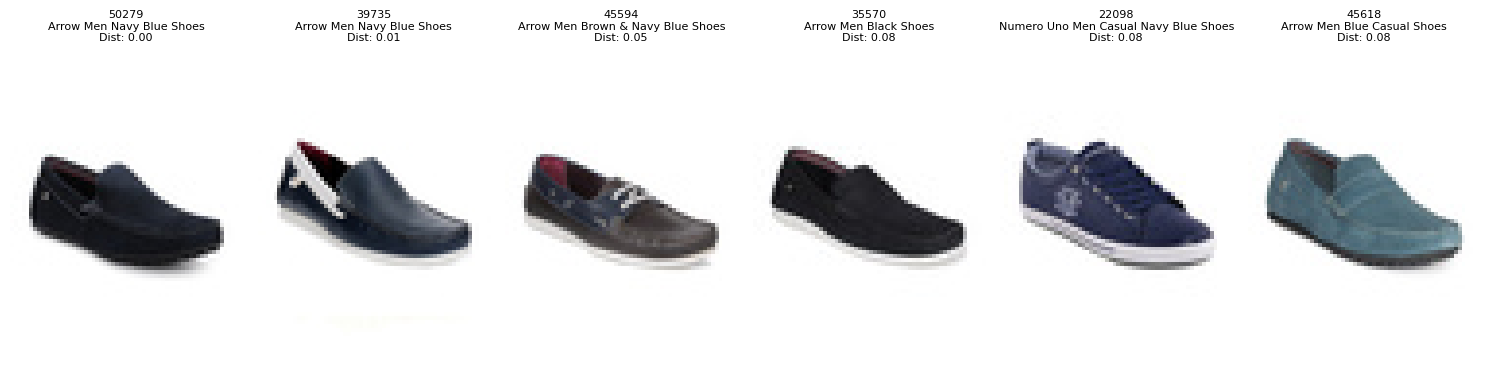

In [108]:
def show_results(indices, distances, ids, text_data):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices[0]):
        prod_id = ids[idx]
        title = text_data[text_data['id'] == int(prod_id)]['productDisplayName'].values[0]
        image_path = f'/content/image_data/image_data/{int(prod_id)}.jpg'
        similarity_score = distances[0][i]

        try:
            img = Image.open(image_path).convert("RGB")
        except:
            img = Image.new('RGB', (224, 224), color='gray')
            title = f"{title} (Image Missing)"

        plt.subplot(1, 6, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{prod_id}\n{title}\nDist: {similarity_score:.2f}", fontsize=8)

    plt.tight_layout()
    plt.show()

# Now call the function with distances
show_results(indices, distances, ids, text_data)

In [78]:
# import pickle
# import pandas as pd
# import numpy as np

# embeddings_file_path = '/content/image_embeddings.pkl'

# clip_dataframe = None

# try:
#     with open(embeddings_file_path, 'rb') as f:
#         embeddings_data = pickle.load(f)

#     print(f"Successfully loaded data from {embeddings_file_path}")
#     print(f"Type of loaded data: {type(embeddings_data)}")
#     if isinstance(embeddings_data, np.ndarray):
#         print(f"Shape of loaded data: {embeddings_data.shape}")

#     clip_dataframe = pd.DataFrame(embeddings_data)

#     print("Created pandas DataFrame 'clip_dataframe'.")
#     print(f"Shape of the DataFrame: {clip_dataframe.shape}")

#     print("\nFirst 5 rows of the DataFrame:")
#     print(clip_dataframe.head())

# except FileNotFoundError:
#     print(f"Error: The file {embeddings_file_path} was not found.")
# except Exception as e:
#     print(f"An error occurred while loading the pickle file or creating the DataFrame: {e}")

In [77]:
# clip_dataframe

In [76]:
# from sklearn.neighbors import NearestNeighbors
# from PIL import Image
# import matplotlib.pyplot as plt
# embeddings = np.vstack(embedding_df['embedding'].values)
# knn = NearestNeighbors(n_neighbors=6, metric='cosine')
# knn.fit(embeddings)

In [75]:
# ids = clip_dataframe['id'].values

# query_index = np.where(ids == '21379')[0][0]

# distances, indices = knn.kneighbors([embeddings[query_index]])

# def show_results(indices, distances, ids, text_data):
#     plt.figure(figsize=(15, 5))
#     for i, idx in enumerate(indices[0]):
#         prod_id = ids[idx]
#         title = text_data[text_data['id'] == int(prod_id)]['productDisplayName'].values[0]
#         image_path = f'/content/image_data/image_data/{int(prod_id)}.jpg'
#         similarity_score = distances[0][i]

#         try:
#             img = Image.open(image_path).convert("RGB")
#         except:
#             img = Image.new('RGB', (224, 224), color='gray')
#             title = f"{title} (Image Missing)"

#         plt.subplot(1, 6, i+1)
#         plt.imshow(img)
#         plt.axis('off')
#         plt.title(f"{prod_id}\n{title}\nDist: {similarity_score:.2f}", fontsize=8)

#     plt.tight_layout()
#     plt.show()

# # Now call the function with distances
# show_results(indices, distances, ids, text_data)